### Configuration

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2,3"

import pandas as pd
import json
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import re
from tqdm import tqdm
from konlpy.tag import Okt
okt = Okt()

MASTER_SEED = 42
TEST_RATIO = 0.1 
SENTIMENT_DATA_DIR = '../data/sentiment/trainset/'
YOUTUBE_DATA_DIR = Path("../data/youtube_comments_by_10_day_50")
TRAINSETS = (
    'korean_sentiment_conversation_train', # 0 # 감성대화말뭉치
    'korean_sentiment_conversation_val', # 1 # 감성대화말뭉치
    'korean_emotion_audio_1', # 2 # 음성데이터셋
    'korean_emotion_audio_2', # 3 # 음성데이터셋
    'korean_emotion_audio_3', # 4 # 음성데이터셋
)
EMOTIONS = {'행복':'happy','분노':'angry','슬픔':'sad','중립':'neutral'}

### Preprocess Data

In [2]:
def preprocess_conversation_df(df1,df2):
    df = pd.concat([df1,df2])
    df.fillna("",inplace=True)
    df['Sentence'] = df['사람문장1'] + ' ' + df['사람문장2'] + ' ' + df['사람문장3']
    df = pd.DataFrame(df.iloc[:,[5, 13]]).replace({'기쁨':'행복'}, regex=True)
    df.rename(columns={'감정_대분류':'labels'}, inplace=True)
    df = df.reset_index(drop=True)
    return df

def preprocess_emotion_audio_df(df1,df2,df3):
    df = pd.concat([df1,df2,df3])
    df_annotations = df.loc[:,'1번 감정':'5번 감정세기'].replace(0, 1) # 0 is neutral
    # 가장 많이 투표된 감정 선택하여 새로운 열에 추가
    def max_voted(row:pd.Series)->str:
        poll = {} # 감정에 대한 투표 결과 저장
        for i in range(5): # 5개 감정과 감정 세기 처리
            emo = row[i*2] # i번째 감정 칼럼의 값
            if emo in poll: # 현재 감정이 poll에 있는지
                poll[emo] += row[i*2+1] # 존재하면 투표 결과 추가
            else: 
                poll[emo] = row[i*2 + 1] # 처음 나오면 새로운 투표 결과 추가
        return max(poll.keys(), key=lambda x:poll[x]).lower() # 투표수 많은 감정 반환
    elected = [] # 가장 많이 선택된 감정 저장
    for r,v in df_annotations.iterrows():
        elected.append(max_voted(v))
    df['labels'] = elected
    df = df.drop(columns=df.columns[2:15]).drop(columns='wav_id')
    emotions= {'fear':'공포', 'surprise':'놀람', 'angry':'분노', 'sadness':'슬픔', 'neutral':'중립', 'happiness':'행복', 'disgust':'혐오'}
    df = df.replace(emotions, regex=True).rename(columns={'발화문':'Sentence'}).reset_index(drop=True)
    return df

def preprocess_old_df(df):
    df = df.where(pd.notnull(df), "")
    df = df[(df['감정_대분류'] == '기쁨') | (df['감정_대분류'] == '분노') | (df['감정_대분류'] == '슬픔')]
    df = df.loc[:,['감정_대분류','사람문장1','사람문장2','사람문장3','사람문장4']].rename(columns={'감정_대분류':'labels'})
    df['Sentence'] = df['사람문장1'].astype(str) + ' ' + df['사람문장2'].astype(str) + ' ' + df['사람문장3'].astype(str) + ' ' + df['사람문장4'].astype(str)
    df = df.drop(columns=df.columns[range(1, 5)]).replace({'기쁨':'행복'}, regex=True).reset_index(drop=True)
    return df

def preprocess_conversation_v2_df(df1,df2):
    df = pd.concat([df1,df2])
    df.fillna("",inplace=True)
    df['Sentence'] = df['사람문장1'] + ' ' + df['사람문장2'] + ' ' + df['사람문장3']
    df = df[ ~df['감정_대분류'].isin(('불안', '당황', '상처')) ]
    df = pd.DataFrame(df.iloc[:,[5, 13]]).replace({'기쁨':'행복'}, regex=True)
    df.rename(columns={'감정_대분류':'labels'}, inplace=True)
    df = df.reset_index(drop=True)
    return df

def preprocess_emotion_audio_v2_df(df1,df2,df3):
    df = pd.concat([df1,df2,df3])
    df_annotations = df.loc[:,'1번 감정':'5번 감정세기'].replace(0, 1) 
    def max_voted(row:pd.Series)->str:
        poll = {} 
        for i in range(5): 
            emo = row[i*2] 
            if emo in poll: 
                poll[emo] += row[i*2+1] 
            else: 
                poll[emo] = row[i*2 + 1] 
        return max(poll.keys(), key=lambda x:poll[x]).lower() 
    elected = [] 
    for r,v in df_annotations.iterrows():
        elected.append(max_voted(v))
    df['labels'] = elected
    df = df.drop(columns=df.columns[2:15]).drop(columns='wav_id')
    emotions= {'fear':'공포', 'surprise':'놀람', 'angry':'분노', 'sadness':'슬픔', 'neutral':'중립', 'happiness':'행복', 'disgust':'혐오'}
    df = df.replace(emotions, regex=True).rename(columns={'발화문':'Sentence'}).reset_index(drop=True)
    df = df[df['labels']=='중립']
    return df

def convert_json_to_df(TEST_DATA_DIR):
    total = 0
    id, pub, chid, vdate, vid, vtitle, text, like = [], [], [], [], [], [], [], []
    for year_dir in TEST_DATA_DIR.iterdir():
        for mon_dir in year_dir.iterdir():
            for day_dir in mon_dir.iterdir():
                for js in day_dir.iterdir():
                    with open(js, 'r', encoding='utf8') as f:
                        data = json.load(f)
                    for cmt in data[1:]:
                        id.append(cmt['snippet']['topLevelComment']['id'])
                        pub.append(cmt['snippet']['topLevelComment']['snippet']['publishedAt'])
                        chid.append(cmt['snippet']['channelId'])
                        vdate.append(data[0]['date'])
                        vid.append(cmt['snippet']['videoId'])
                        vtitle.append(js.name.removesuffix(".json"))
                        text.append(cmt['snippet']['topLevelComment']['snippet']['textOriginal'])
                        like.append(cmt['snippet']['topLevelComment']['snippet']['likeCount'])
                    total += len(data) - 1
    df = pd.DataFrame({'publishedAt' : pub,'channelId': chid,'videoDate': vdate,'videoId': vid,'videoTitle': vtitle,'text': text,'like': like,}, id)
    return df

- Preprocess Sentiment Data

In [5]:
# process data
train_dfs = [pd.read_csv(SENTIMENT_DATA_DIR + trainset + '.csv') for trainset in TRAINSETS]
conversation_all_df = preprocess_conversation_v2_df(train_dfs[0],train_dfs[1])
neutral_df = preprocess_emotion_audio_v2_df(train_dfs[2],train_dfs[3],train_dfs[4])
sentiment_label_df_v2 = pd.concat([conversation_all_df,neutral_df]).reset_index(drop=True)

# save data
# sentiment_label_df_v2.to_csv('../data/sentiment/sentiment_label_df_v2.csv',index=False)
sentiment_label_df_v2['labels'].value_counts()

분노    10417
슬픔    10128
중립     7421
행복     7339
Name: labels, dtype: int64

- Convert Youtube Data json to dataframe

In [6]:
# process data
yotube_df = convert_json_to_df(YOUTUBE_DATA_DIR)
# save data
# yotube_df.to_csv('../data/youtube_df.csv',index=False)
yotube_df.head(3)

,publishedAt,channelId,videoDate,videoId,videoTitle,text,like
UgxGv3vWj0CDw1Yte314AaABAg,2020-08-01T07:32:13Z,UCF4Wxdo3inmxP-Y59wXDsFw,2020-07-30,ncO8E0UHikE,2명 사망·이재민 150명‥충청·전북에 오늘 또 물폭탄 - [LIVE]MBC 뉴스투...,기상청 날씨하나 맞추는게 어렵니?,0
UgzGqLnGrnMy2jlZ9ex4AaABAg,2020-07-31T10:41:35Z,UCF4Wxdo3inmxP-Y59wXDsFw,2020-07-30,ncO8E0UHikE,2명 사망·이재민 150명‥충청·전북에 오늘 또 물폭탄 - [LIVE]MBC 뉴스투...,"뭔 뉴스에 광고가 이리도 많나요? 징허네, 진짜",0
UgyvJRw6Euy7F84PU5N4AaABAg,2020-07-31T09:59:54Z,UCF4Wxdo3inmxP-Y59wXDsFw,2020-07-30,ncO8E0UHikE,2명 사망·이재민 150명‥충청·전북에 오늘 또 물폭탄 - [LIVE]MBC 뉴스투...,잠금만 풀면되지 왜 오래들고 있냐..증거물 없애려고 그러는거 아냐..,0


<AxesSubplot:xlabel='labels', ylabel='count'>

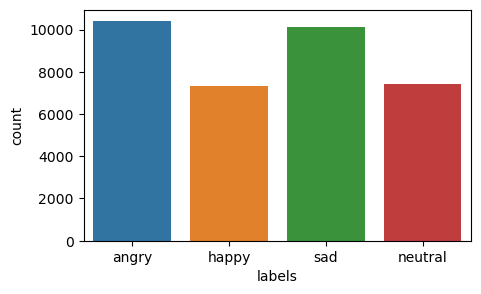

In [13]:
sentiment_label_df_v2['labels'] = sentiment_label_df_v2['labels'].replace(EMOTIONS)
plt.figure(figsize=(5,3))
sns.countplot(x='labels',data=sentiment_label_df_v2)

- Preprocess Youtube Data

In [3]:
# Load Youtube Data
youtube_df = pd.read_csv('../data/youtube_df.csv')
youtube_df = youtube_df[['publishedAt','videoDate','videoTitle','text']]
# Load Stopwords
with open('../data/stopwords.txt', 'r', encoding='utf-8') as f:
    stopwords = f.readlines() 
stopwords = [x.replace('\n','') for x in stopwords]

In [4]:
# Preprocess Text Function
def preprocess_text_data(df):
    # Cleaning(특수문자 제거)
    regex = r'[^\w\s]|\n'
    df['clean_text'] = df['text'].apply(lambda x: re.sub(regex, '', str(x)))
    # 영문자 제거
    regex = r'[a-zA-Z]+'
    df['clean_text'] = df['clean_text'].apply(lambda x: re.sub(regex, '', str(x)))
    # Cleaning(E-mail 주소 제거)
    regex = r'([a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+)'
    df['clean_text'] = df['clean_text'].apply(lambda x: re.sub(regex, '', str(x)))
    # Cleaning(URL 제거)
    regex = r'(http|ftp|https)://(?:[-\w.]|(?:%[\da-fA-F]{2}))+'
    df['clean_text'] = df['clean_text'].apply(lambda x: re.sub(regex, '', str(x)))
    # Cleaning(한글 자음, 모음 제거)
    regex = r'([ㄱ-ㅎㅏ-ㅣ]+)'
    df['clean_text'] = df['clean_text'].apply(lambda x: re.sub(regex, '', str(x)))
    # 년-월-일 형식의 날짜를 찾아서 제거
    regex = r'\d{4}-\d{2}-\d{2}'
    df['clean_text'] = df['clean_text'].apply(lambda x: re.sub(regex, '', str(x)))
    # 월/일/년 형식의 날짜를 찾아서 제거
    regex = r'\d{2}/\d{2}/\d{4}'
    df['clean_text'] = df['clean_text'].apply(lambda x: re.sub(regex, '', str(x)))
    # 월.일.년 형식의 날짜를 찾아서 제거
    regex = r'\d{2}.\d{2}.\d{4}'
    df['clean_text'] = df['clean_text'].apply(lambda x: re.sub(regex, '', str(x)))
    #한문 제거
    regex = r'[\u4e00-\u9fff]+'
    df['clean_text'] = df['clean_text'].apply(lambda x: re.sub(regex, '', str(x)))
    #숫자로만 이루어진 토큰 제거
    regex = r'\b\d+\b'
    df['clean_text'] = df['clean_text'].apply(lambda x: re.sub(regex, '', str(x)))

    # Tokenization & Pos Tagging
    pos_tag = []
    for _, row in tqdm(df.iterrows()):
        news_text = row['clean_text']
        tokens_ko = okt.pos(news_text)
        pos_tag.append(tokens_ko)

    # Normalization
    normalization_li = []
    for pos in pos_tag:
        in_li = []
        for ele in pos:
            if ele[1] in ['Josa', 'Suffix']:
                continue
            in_li.append(ele[0])
        normalization_li.append(in_li)

    # Stopword Removal
    tokens = normalization_li
    token_stop = []
    for token in tokens:
        in_li = []
        for tok in token:
            if len(tok) > 1 and tok not in stopwords:
                in_li.append(tok)
        token_stop.append(in_li)
    
    # Data Save
    token_df = []
    for token in token_stop:
        token_join = ' '.join(token)
        token_df.append(token_join)
    
    # Create DataFrame for preprocess context
    df['preprocess_text'] = token_df
    df.drop('preprocess_text', axis=1, inplace=True)        
    return df

In [5]:
# preprocess_youtube_df
preprocess_youtube_df = preprocess_text_data(youtube_df)
# Save CSV files
preprocess_youtube_df.head(3)
# preprocess_youtube_df.to_csv('../data/preprocess_youtube_df.csv',encoding='utf-8-sig',index=False)

1483209it [3:01:27, 116.90it/s]IOStream.flush timed out
2689461it [8:44:57, 68.84it/s] IOStream.flush timed out
2789220it [9:46:06,  2.30it/s] IOStream.flush timed out
3121501it [14:05:56, 61.50it/s] 


,publishedAt,videoDate,videoTitle,text,clean_text
0,2020-08-01T07:32:13Z,2020-07-30,2명 사망·이재민 150명‥충청·전북에 오늘 또 물폭탄 - [LIVE]MBC 뉴스투...,기상청 날씨하나 맞추는게 어렵니?,기상청 날씨하나 맞추는게 어렵니
1,2020-07-31T10:41:35Z,2020-07-30,2명 사망·이재민 150명‥충청·전북에 오늘 또 물폭탄 - [LIVE]MBC 뉴스투...,"뭔 뉴스에 광고가 이리도 많나요? 징허네, 진짜",뭔 뉴스에 광고가 이리도 많나요 징허네 진짜
2,2020-07-31T09:59:54Z,2020-07-30,2명 사망·이재민 150명‥충청·전북에 오늘 또 물폭탄 - [LIVE]MBC 뉴스투...,잠금만 풀면되지 왜 오래들고 있냐..증거물 없애려고 그러는거 아냐..,잠금만 풀면되지 왜 오래들고 있냐증거물 없애려고 그러는거 아냐
